In [1]:
import json
import os

import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator, lp_by_lf



def neuron_output(neuron, signal_freq, shift_degrees=0, phase_number=20):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > ((phase_number-1)/signal_freq) * clk_freq + shift_samples) &
        (y_events < ((phase_number/signal_freq) * clk_freq) + shift_samples)
    ]
    if len(y_events) == 0:
        return y_events
    # y_events -= int(((phase_number-1)/signal_freq) * clk_freq + shift_samples)
    return y_events

def events_to_spikes(events, run_window=0, spikes_arr_size=-1):
    if spikes_arr_size == -1:
        y_spikes = np.zeros(events[-1] + 1)
    else:
        y_spikes = np.zeros(spikes_arr_size)

    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

def amplify_spikes(base_spikes, spikes_window, base_min, base_max, amplify):
    base_spikes = events_to_spikes(base_spikes-resonator_input[0], spikes_arr_size=int(clk_freq/freq0)+1)
    result = np.zeros_like(base_spikes)
    result[np.arange(len(base_spikes)) % 2 == 1] = 1
    dc = (base_max + base_min)/2
    for i in range(spikes_window, len(result), spikes_window):
        slice_spikes = base_spikes[i:i+spikes_window]
        if len(slice_spikes) < spikes_window:
            break
        curr_spikes = np.sum(slice_spikes) - dc
        new_spikes = int(curr_spikes * amplify)

        if new_spikes > 0:
            spikes_ts = np.linspace(0, spikes_window, new_spikes).astype(int)//2*2 + i
            result[spikes_ts] = 1
        else:
            spikes_ts = np.linspace(0, spikes_window, abs(new_spikes)).astype(int)//2*2 - 1 + i
            result[spikes_ts] = 0
    result = np.where(result == 1)[0]
    return result

def smooth(arr, size):
    filter = np.exp(-(np.arange(size) - size//2)**2 / (2 * (size/4)**2))
    normalized_filter = filter / np.sum(filter)
    res = np.convolve(arr, normalized_filter, 'same')
    res[:size] = arr[:size]
    res[-size:] = arr[-size:]
    return res

clk_freq = 1536000
freq0 = 212
lf = 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
freq0 = freq_of_resonator(clk_freq, lf, best_lp)

duration = 25 / freq0
x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)
freq0

212.2065907891938

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


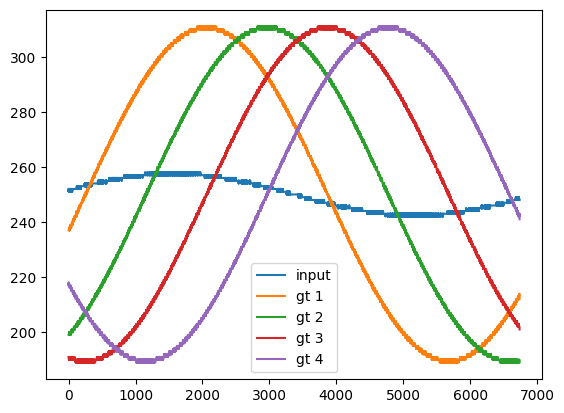

In [2]:
%matplotlib inline

spikes_window = 500
resonator = SpikingNetwork(clk_freq)
resonator.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))

wave_length = int(clk_freq/freq0)
resonator.log_out_spikes(-1)
resonator.input_full_data(sine_wave)

resonator_input = neuron_output(resonator.neurons[0], freq0, shift_degrees=0)
rresonator_input = events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1)

ground_truth = []
# phase_shifts = [22.5, 67.5, 112.5, 157.5]
# phase_shifts = [22.5] + [45]*3
phase_shifts = [25] + [45]*3
phase_shifts = np.cumsum(phase_shifts)
for phase_shift in phase_shifts:
    phase_shift /= 360
    resonator.input_full_data(sine_wave[int((1-phase_shift)*wave_length):int((20-phase_shift)*wave_length)])
    resonator.log_out_spikes(-1)
    resonator.forget_logs()

    resonator.input_full_data(8*sine_wave[int((1-phase_shift)*wave_length):])
    ground_truth.append(neuron_output(resonator.neurons[0], freq0))

gt1 = ground_truth[0]
gt2 = ground_truth[1]
gt3 = ground_truth[2]
gt4 = ground_truth[3]
rolling_gt = []
plt.plot(rresonator_input, label=f'input')
for i, gt in enumerate(ground_truth):
    rolling_gt.append(events_to_spikes(gt-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1))
    plt.plot(rolling_gt[i], label=f'gt {i+1}')

gt_wave_amplitudes = [(o.max(), o.min()) for o in rolling_gt]

plt.legend()
plt.show()

In [3]:

def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def learning_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
        ground_truths,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    network = simple_resonator(freq0, clk_freq, lf, thetas, weights)
    tau = network.clk_freq * time_to_learn / 2
    network.neurons[1].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[0])
    for i in range(3):
        network.neurons[2+i].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[1 + i])
    return network

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons[1:]:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:]]

def argmax(arr):
    return .5 * (np.argmax(arr) + len(arr) - np.argmax(arr[::-1]) - 1)

## Bias + Weights Learning

In [10]:
# chosen_bias=[-1, -5, -5, -5]
# chosen_weights=[11, 9, 10, 10, 10]

chosen_bias=np.array([-0.71, -16.348, -21.148, -20.309]) + 1
chosen_weights=np.array([47.265, 46.16, 32.94, 42.332, 40.631]) - 2


chosen_bias=[-55.591, -20.705, -19.534, -19.953]
chosen_weights=[137.906, 26.708, 41.495, 39.058, 39.883]



In [11]:
resonator = learning_resonator(
    freq0=freq0,
    clk_freq=clk_freq,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
    ground_truths=ground_truth,
    A=2e-4,
    time_to_learn=1e-5,
    max_weight=np.inf,
    min_weight=-np.inf,
)
learning_rules = [neuron.supervised_stdp for neuron in resonator.neurons[1:]]
for i, neuron in enumerate(resonator.neurons):
    resonator.log_out_spikes(i)
    neuron.supervised_stdp = None

momentum_beta = .0

<IPython.core.display.Javascript object>


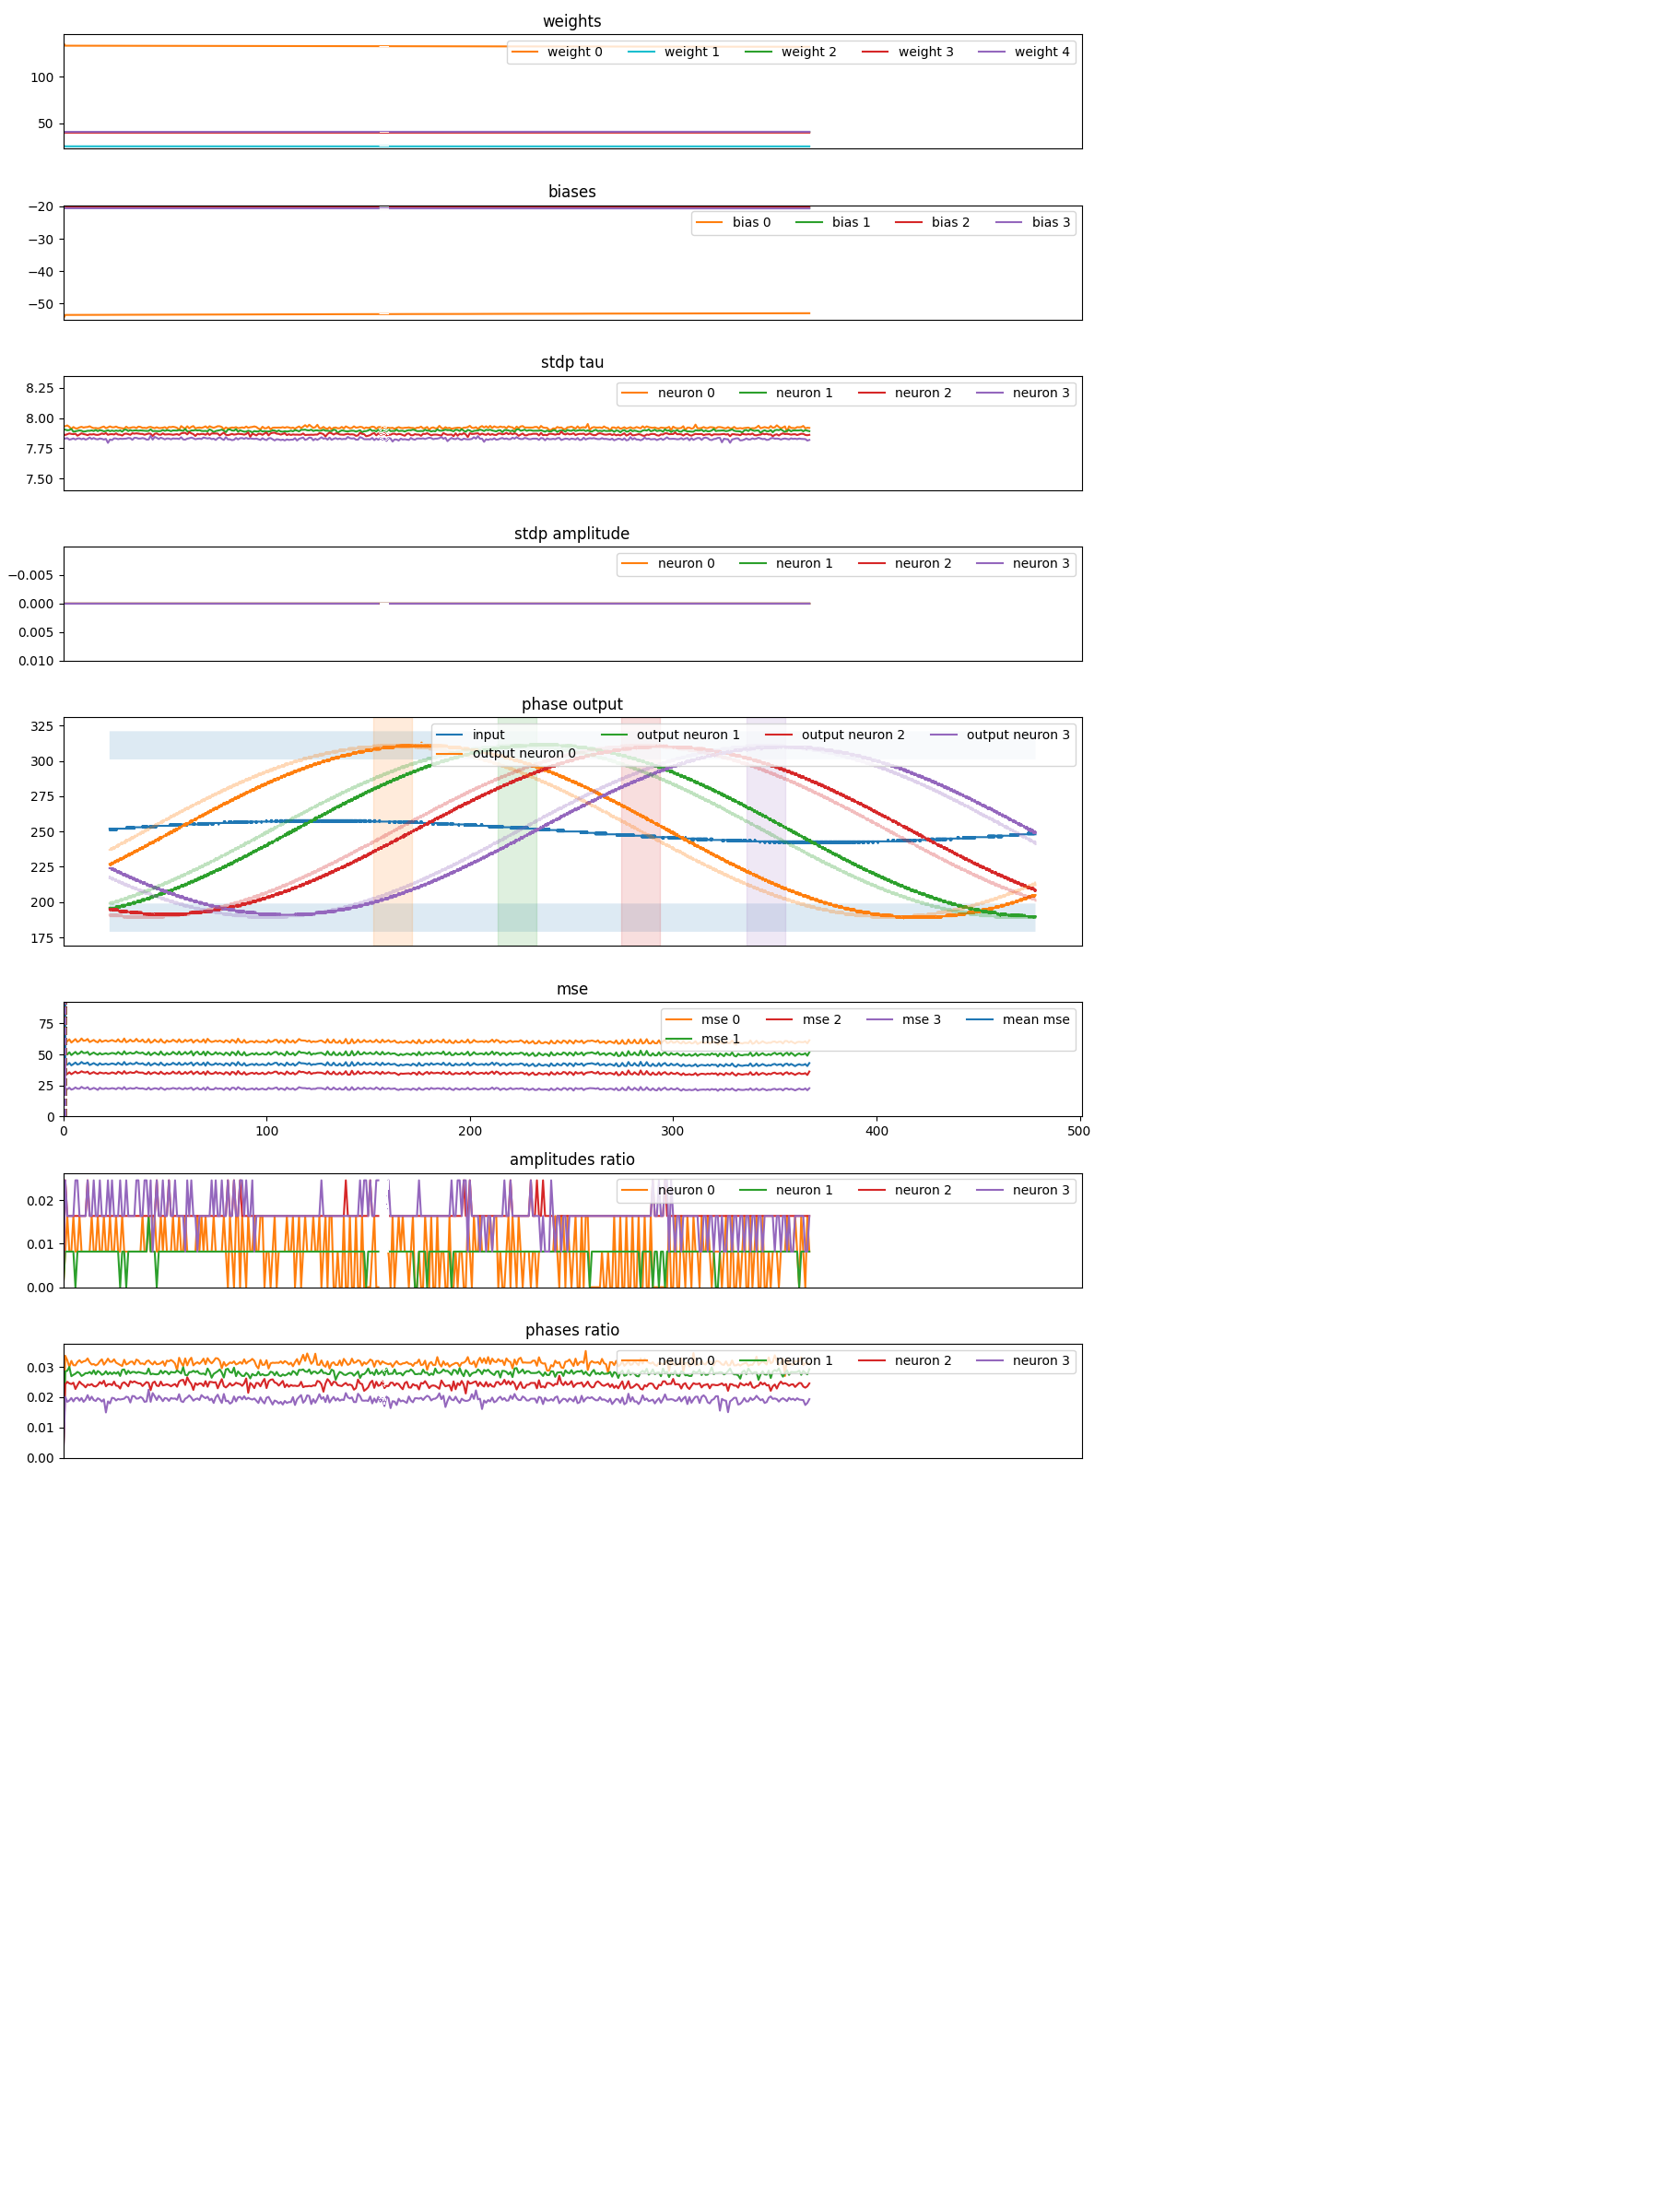

0it [00:00, ?it/s]/var/folders/tr/xv0q465d407gvt0jh8h892zw0000gn/T/ipykernel_30949/20676092.py:251: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[amplitude_gt_ratio_axs].set_ylim(amplitude_ratio[:i, :].min() * .93, amplitude_ratio[:i, :].max() * 1.07)
/var/folders/tr/xv0q465d407gvt0jh8h892zw0000gn/T/ipykernel_30949/20676092.py:252: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[phase_gt_ratio_axs].set_ylim(phase_ratio[:i, :].min() * .93, phase_ratio[:i, :].max() * 1.07)
0it [00:00, ?it/s, weights=[135.874, 26.363, 41.079, 39.626, 40.331], thetas=[-54.74, -20.501, -19.797, -20.163], mse=43.7, amplitudes=[(312.0, 187.0), (313.0, 188.0), (311.0, 191.0), (310.0, 192.0)], dc=[252.22151335311574, 254.63071216617212, 254.2045994065282, 251.77982195845698], tuned_parameters=4]

0
1
2
3


867it [23:04,  1.70s/it, weights=[131.705, 25.621, 41.088, 40.288, 41.205], thetas=[-53.013, -20.518, -20.159, -20.634], mse=40.3, amplitudes=[(312.0, 189.0), (312.0, 189.0), (311.0, 191.0), (311.0, 190.0)], dc=[252.68293768545993, 255.04094955489614, 254.3660237388724, 251.48338278931752], tuned_parameters=5] 

In [ ]:
%matplotlib notebook
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

def_color = '#1f77b4'
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
epochs = 500

weights_axs = 0
bias_axs = 1
phase_axs = 4
stdp_amplitude_axs = 3
stdp_tau_axs = 2
mse_axs = 5
amplitude_gt_ratio_axs = 6
phase_gt_ratio_axs = 7

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

biases = np.zeros((epochs+1, 4))
biases[0, :] = flat_thetas(resonator)

mses = np.ones((epochs+1, 5)) * np.inf
mses[0, :4] = np.array([(gt**2).mean() for gt in ground_truth])
mses[0, 4] = mses[0, :4].mean()
min_mse = mses[0, 4]

stdp_amplitude = np.ones((epochs+1, 4)) * np.inf
stdp_amplitude[0, :] = np.array([lr.A for lr in learning_rules])

amplitude_ratio = np.zeros((epochs+1, 4))

stdp_tau = np.ones((epochs+1, 4)) * np.inf
stdp_tau[0, :] = np.array([lr.tau for lr in learning_rules])

phase_ratio = np.zeros((epochs+1, 4))

heights_ratios = np.ones(8)
heights_ratios[phase_axs] = 2
fig, axs = plt.subplots(8, 1, figsize=(12, 16), gridspec_kw={'height_ratios': heights_ratios})
axs[weights_axs].set_title('weights')
axs[weights_axs].set_xlim(0, epochs+1)
axs[weights_axs].set_xticks([])
weights_lines = [axs[weights_axs].plot([w], label=f'weight {i}', color=c)[0] for i, (c, w) in enumerate(zip([colors[0], '#17becf'] + colors[1:], weights[0]))]


axs[bias_axs].set_title('biases')
axs[bias_axs].set_xlim(0, epochs+1)
axs[bias_axs].set_xticks([])
biases_lines = [axs[bias_axs].plot([w], label=f'bias {i}', color=colors[i])[0] for i, w in enumerate(biases[0])]

y_epsilon = spikes_window * 0.020
x_epsilon = len(rresonator_input) * 7.5 / 360

gt_peaks = [argmax(gt) for gt in rolling_gt]
x_phase = np.arange(0, len(rresonator_input))
axs[phase_axs].set_title('phase output')
axs[phase_axs].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
axs[phase_axs].set_xticks([])
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=def_color, alpha=0.15)
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=def_color, alpha=0.15)

axs[phase_axs].plot(rresonator_input, label='input', color=def_color)
phase_lines = [axs[phase_axs].plot(gt, label=f'output neuron {i}', color=colors[i])[0] for i, gt in enumerate(rolling_gt)]
[axs[phase_axs].plot(gt, color=colors[i], alpha=.3)[0] for i, gt in enumerate(rolling_gt)]
[axs[phase_axs].axvspan(peak - x_epsilon, peak + x_epsilon, alpha=0.15, color=colors[i]) for i, peak in enumerate(gt_peaks)]

axs[mse_axs].set_title('mse')
axs[mse_axs].set_xlim(0, epochs+1)
axs[mse_axs].set_ylim(0, 10000)
mse_lines = [axs[mse_axs].plot([mse], label=f'mse {i}' if i < 4 else 'mean mse', color=color)[0]
             for i, (color, mse) in enumerate(zip(colors + [def_color], mses[0]))]

axs[stdp_amplitude_axs].set_title('stdp amplitude')
axs[stdp_amplitude_axs].set_xlim(0, epochs+1)
axs[stdp_amplitude_axs].set_xticks([])
stdp_ampl_lines = [axs[stdp_amplitude_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(stdp_amplitude[0])]

axs[amplitude_gt_ratio_axs].set_title('amplitudes ratio')
axs[amplitude_gt_ratio_axs].set_xlim(0, epochs+1)
axs[amplitude_gt_ratio_axs].set_xticks([])
ampl_ratio_lines = [axs[amplitude_gt_ratio_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(amplitude_ratio[0])]

axs[stdp_tau_axs].set_title('stdp tau')
axs[stdp_tau_axs].set_xlim(0, epochs+1)
axs[stdp_tau_axs].set_xticks([])
stdp_tau_lines = [axs[stdp_tau_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(stdp_tau[0])]

axs[phase_gt_ratio_axs].set_title('phases ratio')
axs[phase_gt_ratio_axs].set_xlim(0, epochs+1)
axs[phase_gt_ratio_axs].set_xticks([])
phase_ratio_lines = [axs[phase_gt_ratio_axs].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(amplitude_ratio[0])]

fig.tight_layout()

areas_sns = [[],[],[],[]] 
start_sns = [-1] * 4
momentum = [0] * 4
max_theta = -0.75
tuned_parameters = 0
count_after_tune = -1
with tqdm() as pbar:
    i = 1
    while count_after_tune != 0:
        count_after_tune -= 1
        run_with_stdp = True
        tuned_parameters = 0
        for neuron in resonator.neurons:
            neuron.membrane_potential = 0
            neuron.log_rand_gauss_var = 0
        resonator.forget_logs()
        resonator.input_full_data(sine_wave)

        # mse
        output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                                   run_window=spikes_window,
                                   spikes_arr_size=int(clk_freq/freq0)+1)
                  for neuron in resonator.neurons[1:]]
        max_y = 0
        mses[i, :4] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
        mses[i, 4] = mses[i, :4].mean()
        if mses[i, 4] < min_mse:
            min_mse = mses[i, 4]
            run_with_stdp = False
        for j, line in enumerate(mse_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(mses[:i, j])
            max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
        axs[mse_axs].set_ylim(0, max_y)
#         axs[mse_axs].set_ylim(0, 1000)
        for j, sns in enumerate(start_sns):
            if sns != -1:
                axs[mse_axs].axvline(sns, color=colors[j], linestyle='--')

        # weights chart
        weights[i, :] = flat_weights(resonator)
        for j, line in enumerate(weights_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(weights[:i, j])
        max_y = 1.1*weights[max(0, i-4):i+1, :].max()
        min_y = 0.9*weights[max(0, i-4):i+1, :].min()
        axs[weights_axs].set_ylim(min_y, max_y)

        # phase chart
        for j, o in enumerate(output):
            phase_lines[j].set_ydata(o)

        # biases chart
        biases[i, :] = flat_thetas(resonator)
        for j, line in enumerate(biases_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(biases[:i, j])
        max_y = biases[:i+1, :].max() + 0.2
        min_y = biases[:i+1, :].min() - 0.2
        axs[bias_axs].set_ylim(min_y, max_y)

        # stdp charts:
        for j, lr in enumerate(learning_rules):
            stdp_amplitude[i, j] = lr.A
            stdp_ampl_lines[j].set_xdata(np.arange(i))
            stdp_ampl_lines[j].set_ydata(stdp_amplitude[:i, j])
            stdp_tau[i, j] = lr.tau
            stdp_tau_lines[j].set_xdata(np.arange(i))
            stdp_tau_lines[j].set_ydata(stdp_tau[:i, j])
        axs[stdp_amplitude_axs].set_ylim(stdp_amplitude[:i, :].min() * .9+.01, stdp_amplitude[:i, :].max() * 1.05 - .01)
        axs[stdp_tau_axs].set_ylim(stdp_tau[:i, :].min() * .95, stdp_tau[:i, :].max() * 1.05)

        thetas_shift = [-.2*(((2*np.mean(o) - spikes_window)/spikes_window)**2)*np.sign(np.mean(o)-spikes_window/2) for o in output]
        for j, neuron in enumerate(resonator.neurons[1:]):
            bs = thetas_shift[j]
            momentum[j] = bs + momentum_beta * momentum[j]
            neuron.theta += momentum[j]
            if neuron.theta > max_theta:
                neuron.theta = max_theta

        peaks = [argmax(o)for o in output]
        # activate weights learning
        for j, o in enumerate(output):
            dc = o.mean()
            o_max = o.max()
            o_min = o.min()
            neuron = resonator.neurons[1+j]
            # first 2 conditions to check if the amplitude is on the right place.
            # next condition is to check if the peak is in the right place.
            o_argmax = argmax(o)

            if (abs(o_argmax - gt_peaks[j]) <= 3 * x_epsilon #and
#                 abs(o_max - gt_wave_amplitudes[j][0]) > y_epsilon/4 and
#                 abs(o_min - gt_wave_amplitudes[j][1]) > y_epsilon/4
            
#             if ((j == 0 and (o_max - o_min) > 68) or
#                 (j == 1 and (o_max - o_min) > 70) or
#                 (j == 2 and (o_max - o_min) > 72) or
#                 (j == 3 and (o_max - o_min) > 74) and
#                 abs(o_argmax - gt_peaks[j]) <= 2 * x_epsilon
               ):
                if start_sns[j] == -1:
                    start_sns[j] = i
                    print(j)
                areas_j = areas_sns[j]
                if areas_j == [] or len(areas_j[-1]) == 2:
                    areas_j.append((i, ))
                # 100 mse -> stretch_or_shrink_scale 0.001
                stretch_or_shrink_scale = 5*(mses[i, j]*1000//1e4) / 1e4
                if gt_wave_amplitudes[j][1] < o_min < o_max < gt_wave_amplitudes[j][0]:
                    neuron.theta -= stretch_or_shrink_scale
                    neuron.synapses_weights[0] += 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] -= 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
                elif o_min < gt_wave_amplitudes[j][1] < gt_wave_amplitudes[j][0] < o_max:
                    stretch_or_shrink_scale *= 2
                    neuron.theta += stretch_or_shrink_scale
                    neuron.synapses_weights[0] -= 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] += 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
            else:
                areas_j = areas_sns[j]
                if areas_j != [] and len(areas_j[-1]) == 1:
                    areas_j[-1] = (areas_j[-1][0], i)
            if abs(o_argmax - gt_peaks[j]) <= x_epsilon:
                tuned_parameters += 1
            if (abs(o_max - gt_wave_amplitudes[j][0]) <= y_epsilon and
                abs(o_min - gt_wave_amplitudes[j][1]) <= y_epsilon
            ):
                tuned_parameters += 1
            if not run_with_stdp:
                neuron.supervised_stdp = None
                amplitude_ratio[i, j] = amplitude_ratio[i-1, j]
                phase_ratio[i, j] = phase_ratio[i-1, j]
            else:
                wave_amplitude = o_max - o_min
                gt_wave_amplitude = gt_wave_amplitudes[j][0] - gt_wave_amplitudes[j][1]
                wave_amplitude_ratio = abs((wave_amplitude - gt_wave_amplitude)/gt_wave_amplitude)        # number between 0 - 1 represent [0 - gt_wave_amplitude]
                phase_diff_ratio = abs(peaks[j] - gt_peaks[j]) / len(o)                                   # number between 0 - 1 represent [0 - 180]
                neuron.supervised_stdp = learning_rules[j]
                neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 10e-5
                neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 5e-5
                neuron.supervised_stdp.tau = 1 * 1e-5 * clk_freq / 2 * (1 + phase_diff_ratio)
                
                amplitude_ratio[i, j] = wave_amplitude_ratio
                ampl_ratio_lines[j].set_xdata(np.arange(i))
                ampl_ratio_lines[j].set_ydata(amplitude_ratio[:i, j])
                
                phase_ratio[i, j] = phase_diff_ratio
                phase_ratio_lines[j].set_xdata(np.arange(i))
                phase_ratio_lines[j].set_ydata(phase_ratio[:i, j])

        axs[amplitude_gt_ratio_axs].set_ylim(amplitude_ratio[:i, :].min() * .93, amplitude_ratio[:i, :].max() * 1.07)
        axs[phase_gt_ratio_axs].set_ylim(phase_ratio[:i, :].min() * .93, phase_ratio[:i, :].max() * 1.07)
        
        wave_amplitudes = [(o.max(), o.min()) for o in output]
        pbar.set_postfix({'weights': flat_weights(resonator).tolist(), 'thetas': flat_thetas(resonator), 'mse': mses[i, :].mean(),
                          'amplitudes': wave_amplitudes, 'dc': [o.mean() for o in output], 'tuned_parameters': tuned_parameters})

        for j in range(8):
            axs[j].legend(loc='upper right',  ncol=5 if j < 4 else 4)

        fig.canvas.draw()
        fig.canvas.flush_events()

        pbar.update(1)
        i = (i+1) % epochs
        if i == 0:
            i = 1
        
        if tuned_parameters == 8 and count_after_tune < 0:
            count_after_tune = 100
            print('tune')
            print('weights', list(weights[i-1]))
            print('thetas', list(biases[i-1]))
            print('mse', list(mses[i-1]))

In [596]:
min_mse = np.argmin(mses[:i-1].mean(axis=1))
# min_mse = i-1
print(f'min mse {mses[min_mse].mean()}')
chosen_bias = biases[min_mse]
chosen_weights = weights[min_mse]
print(f'chosen_bias={chosen_bias.tolist()}')
print(f'chosen_weights={chosen_weights.tolist()}')

min mse 58.822143916913944
chosen_bias=[-57.708, -24.052, -20.197, -20.197]
chosen_weights=[135.537, 20.229, 48.009, 40.414, 40.438]


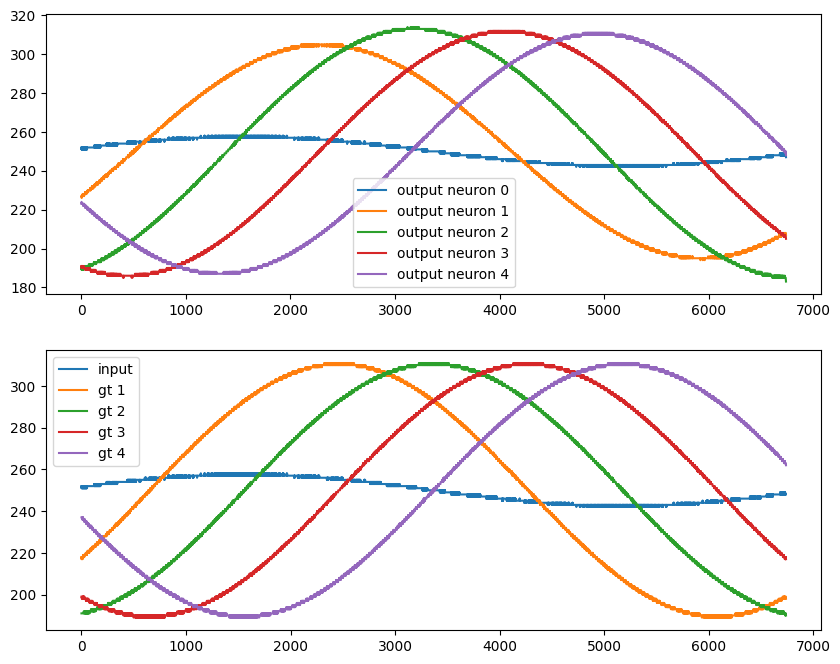

In [597]:
%matplotlib inline
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                           run_window=spikes_window,
                           spikes_arr_size=int(clk_freq/freq0)+3)
          for neuron in res_resonator.neurons]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, o in enumerate(output):
    axs[0].plot(o, label=f'output neuron {i}')
axs[0].legend()
axs[1].plot(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window), label=f'input')
for i, gt in enumerate(rolling_gt):
    axs[1].plot(gt, label=f'gt {i+1}')

axs[1].legend()

# 212.2065907891938 ~ peak 187.755 nid 1 snr 5.699
# chosen_bias=[-57.708, -24.052, -20.197, -20.197]
# chosen_weights=[135.537, 20.229, 48.009, 40.414, 40.438]
f0 = 181.9720430905394
f0/2 = 291.54661196685674
Q factor 147.31827591569808, f1 = 87.54233269070093, f2 = 234.860608606399


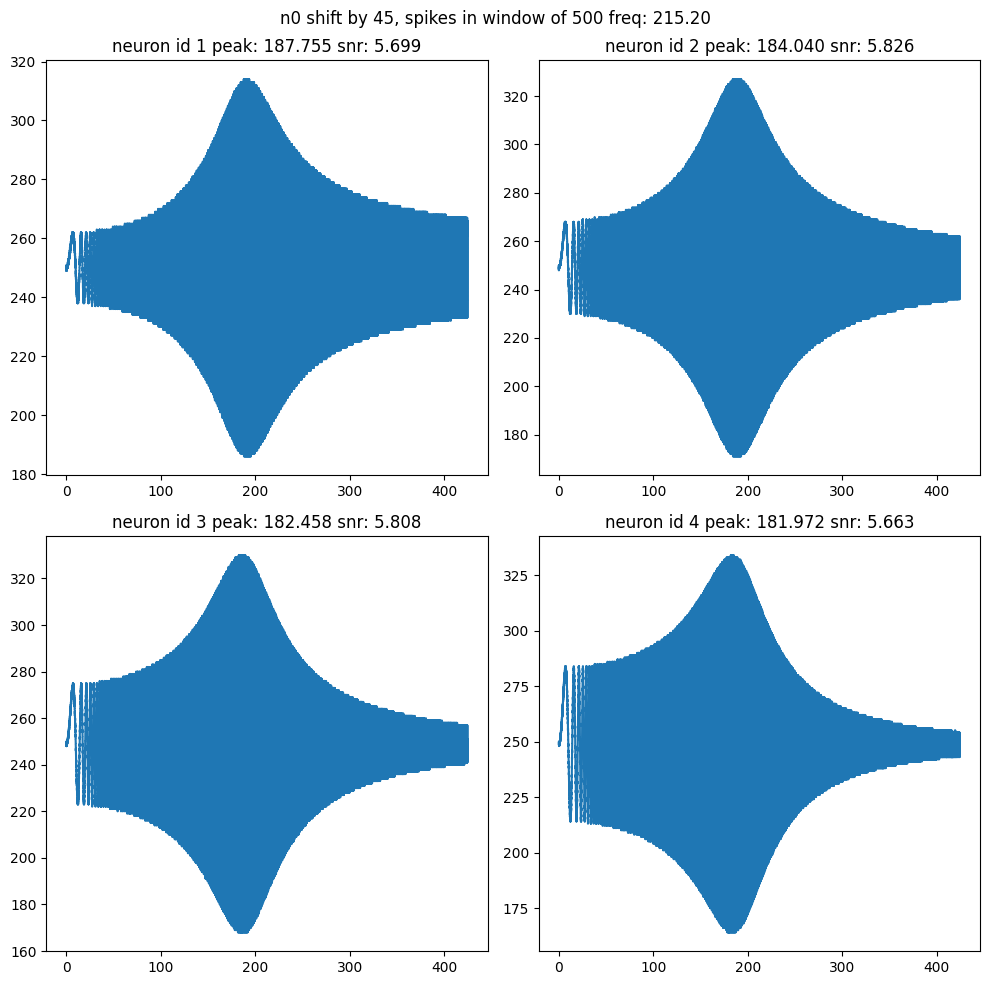

In [598]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
clk_freq = 1_536_000
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 2 * freq0
res_resonator.forget_logs()

step = 100/(clk_freq)
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    snr_spikes = y_spikes[3000:]
    snr[nid] = (snr_spikes.max() - snr_spikes.min())/snr_spikes.std()
    peak[nid] = x[3000+np.argmax(snr_spikes)]
    ax.set_title(f'neuron id {nid + 1} peak: {peak[nid]:.3f} snr: {snr[nid]:.3f}')
fig.tight_layout()

nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'f0 = {x[y_spikes == y_spikes.max()][0]}')
print(f'f0/2 = {f2}')
print(f'Q factor {arg_Q[-1] - arg_Q[0]}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')

## Improve DC

In [ ]:
np.argmin(mses.mean(axis=1))

In [36]:
from snn.spiking_neuron import BINARY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
from snn.resonator import trained_resonator

freq0 = 63.6
clk_freq=153600
resonator = trained_resonator(
    freq0=float(freq0),
    filters_folder='filters4_xi0'
)

neuron = create_SCTN()
neuron.synapses_weights = np.array([3.0])
neuron.leakage_period = np.inf
neuron.theta = -1
neuron.threshold_pulse = 3
neuron.reset_to = 1.5
neuron.activation_function = BINARY
resonator.add_layer(SCTNLayer([neuron]))

neuron = create_SCTN()
neuron.synapses_weights = np.array([10.0])
neuron.leakage_period = np.inf
neuron.theta = 0
neuron.leakage_factor = 1
neuron.leakage_period = 1
neuron.threshold_pulse = 30
neuron.reset_to = 10
neuron.activation_function = BINARY
resonator.add_layer(SCTNLayer([neuron]))

In [11]:
from snn.spiking_neuron import BINARY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
from snn.resonator import trained_resonator, delta_resonator

freq0 = 15.9
clk_freq=153600
resonator = delta_resonator(
    freq0=float(freq0),
    filters_folder='filters4_xi0'
)


7.95 6.510416666666667e-06 2442240 153600


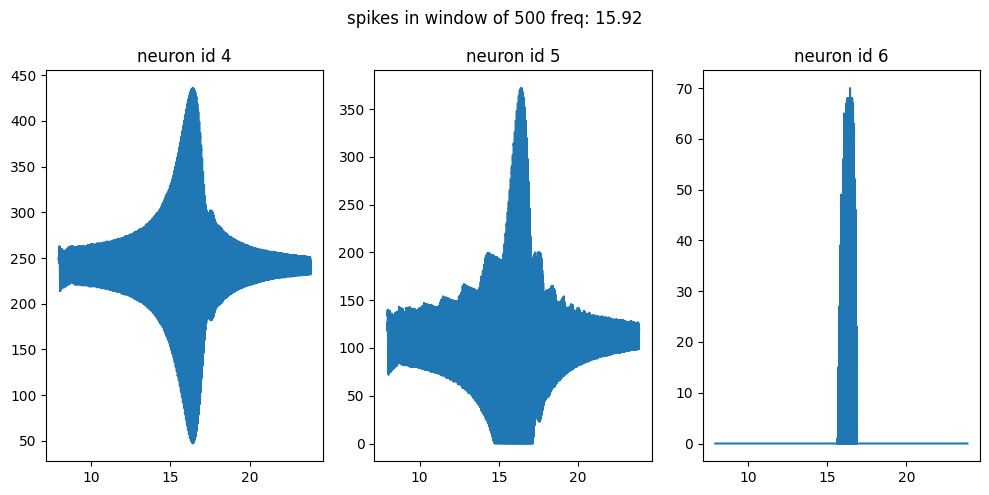

In [12]:
neuronds_id = [4, 5, 6]
for nid in neuronds_id:
    resonator.log_out_spikes(nid)

start_freq = freq0 / 2
spectrum = freq0
resonator.forget_logs()

step = 1/clk_freq
test_size = int(spectrum / step)
print(start_freq, step, test_size, clk_freq)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(1, len(neuronds_id), figsize=(10, 5))
fig.suptitle(f'spikes in window of {spikes_window} freq: {f_resonator:.2f}')
spikes_window = 500
for nid in neuronds_id:
    spikes_neuron = resonator.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid - neuronds_id[0]]
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid}')
fig.tight_layout()